In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import configparser
import re
from astropy import units as u
from astropy.constants import c,m_p,k_B
from astropy.visualization import quantity_support
import os


In [82]:
cd ~/Documents/

/home/astromix/Documents


In [84]:
cd Jet_Cloud/

/home/astromix/Documents/Jet_Cloud


In [85]:
ls

'cloudx=0.5_radiuscloud=1_rho=-2.npz'  'cloudx=0.5_radiuscloud=1_rho=4.npz'
'cloudx=0.5_radiuscloud=1_rho-3.npz'   'cloudx=1_radiuscloud=0.5_rho=-2.npz'


In [88]:
D=np.load('cloudx=0.5_radiuscloud=1_rho=4.npz')

In [97]:
D['X'].shape,D['Y'].shape,D['TMP'][:,:,10].shape

((1024,), (2048,), (1024, 2048))

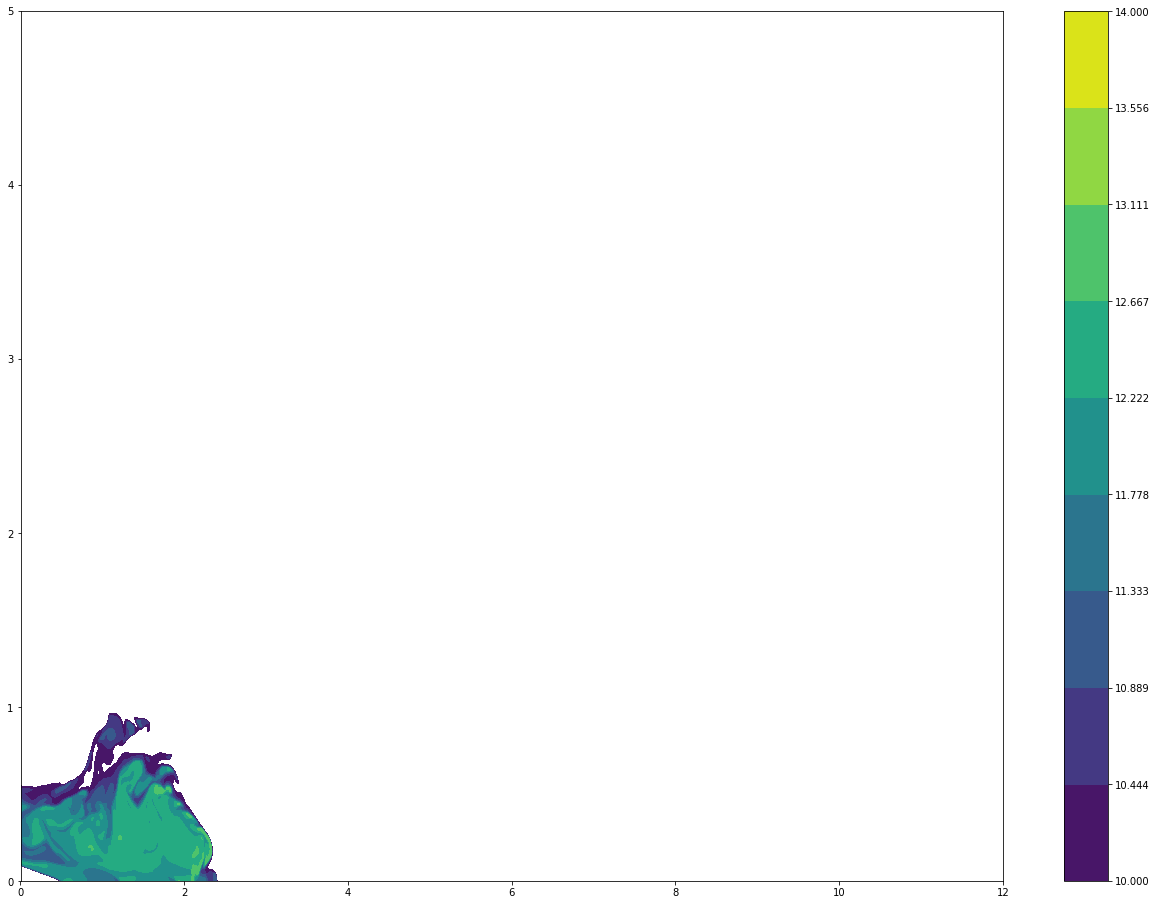

In [103]:
plt.contourf(D['Y'],D['X'],np.log10(D['TMP'][:,:,-1]),levels=np.linspace(10,14,10))
plt.colorbar()

In [2]:
cd ../test3/

/home/astromix/astro/JetCloudSim/test3


In [11]:
config = configparser.ConfigParser(allow_no_value=True,delimiters=' ')
config.read('pluto.ini')

['pluto.ini']

In [110]:
k_B.cgs

<Quantity 1.38064852e-16 erg / K>

In [108]:
PU['prs']*1e-8/m_p

<Quantity 8.97346346e+15 Ba / kg>

In [15]:
config.items('Parameters')

[('radius_cloud', '1.0  #Initial Radius of Cloud'),
 ('rho_ism', '1.0  #ISM Density'),
 ('cloudx', '1.0'),
 ('cloudy', '3.0'),
 ('rho_jet', '1.0e-2  #Density of the Jet'),
 ('lorentz_jet', '4.0  #Lorentz Parameter for the Jet'),
 ('pressure_gas', '1.0e-8  #4.76193e-10 #1.0e-8 #Cloud pressure'),
 ('pressure_jet_thermal', '1.0e-8  #4.76193e-10 #Jet Pressure 1e-9'),
 ('jet_window', '0.1'),
 ('r0tor', '0.2'),
 ('gjet', '1  #BOOL, for jet 1, without jet 0'),
 ('gbphi', '1')]

In [14]:
dict(config.items('Parameters'))

{'radius_cloud': '1.0  #Initial Radius of Cloud',
 'rho_ism': '1.0  #ISM Density',
 'cloudx': '1.0',
 'cloudy': '3.0',
 'rho_jet': '1.0e-2  #Density of the Jet',
 'lorentz_jet': '4.0  #Lorentz Parameter for the Jet',
 'pressure_gas': '1.0e-8  #4.76193e-10 #1.0e-8 #Cloud pressure',
 'pressure_jet_thermal': '1.0e-8  #4.76193e-10 #Jet Pressure 1e-9',
 'jet_window': '0.1',
 'r0tor': '0.2',
 'gjet': '1  #BOOL, for jet 1, without jet 0',
 'gbphi': '1'}

In [12]:
config['Parameters']

<Section: Parameters>

In [4]:
Xstring=re.findall(r"[-+]?\d*\.\d+|\d+", config['Grid']['X1-grid'])
Ystring=re.findall(r"[-+]?\d*\.\d+|\d+", config['Grid']['X2-grid'])
Xmin=float(Xstring[1]);Xmax=float(Xstring[3]);Nx=int(Xstring[2])
Ymin=float(Ystring[1]);Ymax=float(Ystring[3]);Ny=int(Ystring[2])
XX= np.linspace(Xmin,Xmax,Nx)
YY= np.linspace(Ymin,Ymax,Ny)

In [5]:
dblout=np.loadtxt('dbl.out',str)
Nbl=dblout.shape[0]
simvars=dblout[0,6:]
TTall=dblout[:,1].astype(float)

In [6]:
L0=10*u.pc
rho0=1.67e-24*(u.g*u.cm**(-3))
v0=c.cgs

In [7]:
gauss_B = (u.g/u.cm)**(0.5)/u.s
equiv_B = [(u.G, gauss_B, lambda x: x, lambda x: x)]

In [8]:
PU={'rho':rho0,
    'vx1':v0,
    'vx2':v0,
    'vx3':v0,
    'Bx1':(v0*np.sqrt(4.*np.pi*rho0)).to(u.G,equivalencies=equiv_B),
    'Bx2':(v0*np.sqrt(4.*np.pi*rho0)).to(u.G,equivalencies=equiv_B),
    'Bx3':(v0*np.sqrt(4.*np.pi*rho0)).to(u.G,equivalencies=equiv_B),
    'prs':(rho0*v0**2).to(u.Ba),
    'tmp':(v0**2*m_p/k_B).cgs,
    'T':(L0/v0).cgs,
    'L':(L0).cgs}

In [9]:
cwd=os.getcwd()
wdir=cwd+'/'
outdir=cwd[cwd.rfind('/')+1:]

In [110]:
%%time
d=5
start=0
end=Nbl
A=np.fromfile("data.{:04d}.dbl".format(start))
B=A.reshape((simvars.shape[0],Ny,Nx))
M={var:B[start,:,:] for start,var in enumerate(simvars)}
TT=np.array(TTall[start])
for idbl in range(start+1,end,d):
    A=np.fromfile("data.{:04d}.dbl".format(idbl))
    B=A.reshape((simvars.shape[0],Ny,Nx))
    #M=np.dstack((M,{var:B[i,:,:]*PU[var] for i,var in enumerate(simvars)}))
    M=np.append(M,{var:B[i,:,:] for i,var in enumerate(simvars)})
    TT=np.append(TT,TTall[idbl])
    
# TT=TT#*PU['T']
# XX=XX#*PU['L']
# YY=YY#*PU['L']
RHO= np.array([M[i]['rho'] for i,t in enumerate(TT)])#*PU['rho']
PRS= np.array([M[i]['prs'] for i,t in enumerate(TT)])#*PU['prs']
Br= np.array([M[i]['Bx1'] for i,t in enumerate(TT)])#*PU['Bx1']
Bz= np.array([M[i]['Bx2'] for i,t in enumerate(TT)])#*PU['Bx2']
Bphi= np.array([M[i]['Bx3'] for i,t in enumerate(TT)])#*PU['Bx3']
TMP= np.array([M[i]['tmp'] for i,t in enumerate(TT)])#*PU['tmp']
Vr=np.array([M[i]['vx1'] for i,t in enumerate(TT)])#*PU['vx1']
Vz=np.array([M[i]['vx2'] for i,t in enumerate(TT)])#*PU['vx2']
Vphi=np.array([M[i]['vx3'] for i,t in enumerate(TT)])#*PU['vx3']
np.savez_compressed(outdir,RHO=RHO,PRS=PRS,Br=Br,Bz=Bz,Bphi=Bphi,TMP=TMP,Vr=Vr,Vz=Vz,Vphi=Vphi,T=TT,X=XX,Y=YY,PU=PU)

CPU times: user 56.4 s, sys: 4.38 s, total: 1min
Wall time: 57.5 s


In [88]:
simvars

array(['rho', 'vx1', 'vx2', 'vx3', 'Bx1', 'Bx2', 'Bx3', 'prs', 'tmp'],
      dtype='<U12')

In [7]:
M=np.load('test3.npz')
PU=M['PU'].item()

In [8]:
M['PU'].item()['prs']

<Quantity 0.00150092 Ba>

In [10]:
M['T']*PU['T'].to(u.yr)

<Quantity [   0.        ,   32.54217757,  195.63984775,  358.74037832,
            521.80128089,  684.85598648,  847.97592336, 1011.00551491,
           1174.09577156, 1337.18146201, 1500.29781116, 1663.37339077,
           1826.42907484, 1989.48410659, 2152.54598763, 2315.66103216,
           2478.71215004, 2641.78642502, 2804.90505726, 2967.97411374,
           3131.08687518, 3294.17289179, 3457.25108064, 3620.25099197,
           3783.37158116, 3946.40410812, 4109.55405138, 4272.62897867,
           4435.72021379, 4598.75600231, 4761.84397586] yr>

In [5]:
def plot_gamma(M,log=False,rows=3,cols=2):
    scale=(6,10)
    PU=M['PU'].item()
    X=M['X']*PU['L']
    Y=M['Y']*PU['L']
    gamma=1./np.sqrt(1-(M['Vz']**2+M['Vr']**2))
    
    T=np.linspace(0,M['T'].shape[0]-1,rows*cols,dtype=int)

    #with quantity_support():
    fig, axes = plt.subplots(nrows=rows, ncols=cols, sharex=True, sharey=True,figsize=(cols*scale[0],rows*scale[1]))
    for i,ax in enumerate(axes.flat):
        pc=ax.contourf(X.to(u.pc),Y.to(u.pc),gamma[T[i],:,:],levels=np.linspace(gamma.min(),gamma.max(),30),cmap='jet')
        ax.set_title('{:.2f}'.format((M['T'][T[i]]*M['PU']['T']).to(u.yr)))
    plt.tight_layout()
    cbar_ax = fig.add_axes([0., 1.015, 1., 0.025*(np.float(cols)/rows)])#*(np.float(cols)/rows)
    cb=fig.colorbar(pc, cax=cbar_ax,orientation="horizontal",label='Gamma')
    cb.ax.tick_params(labelsize=17)
    cb.ax.xaxis.offsetText.set(size=20)
    cb.ax.xaxis.set_ticks_position('top')
    cb.ax.xaxis.set_label_position('top')

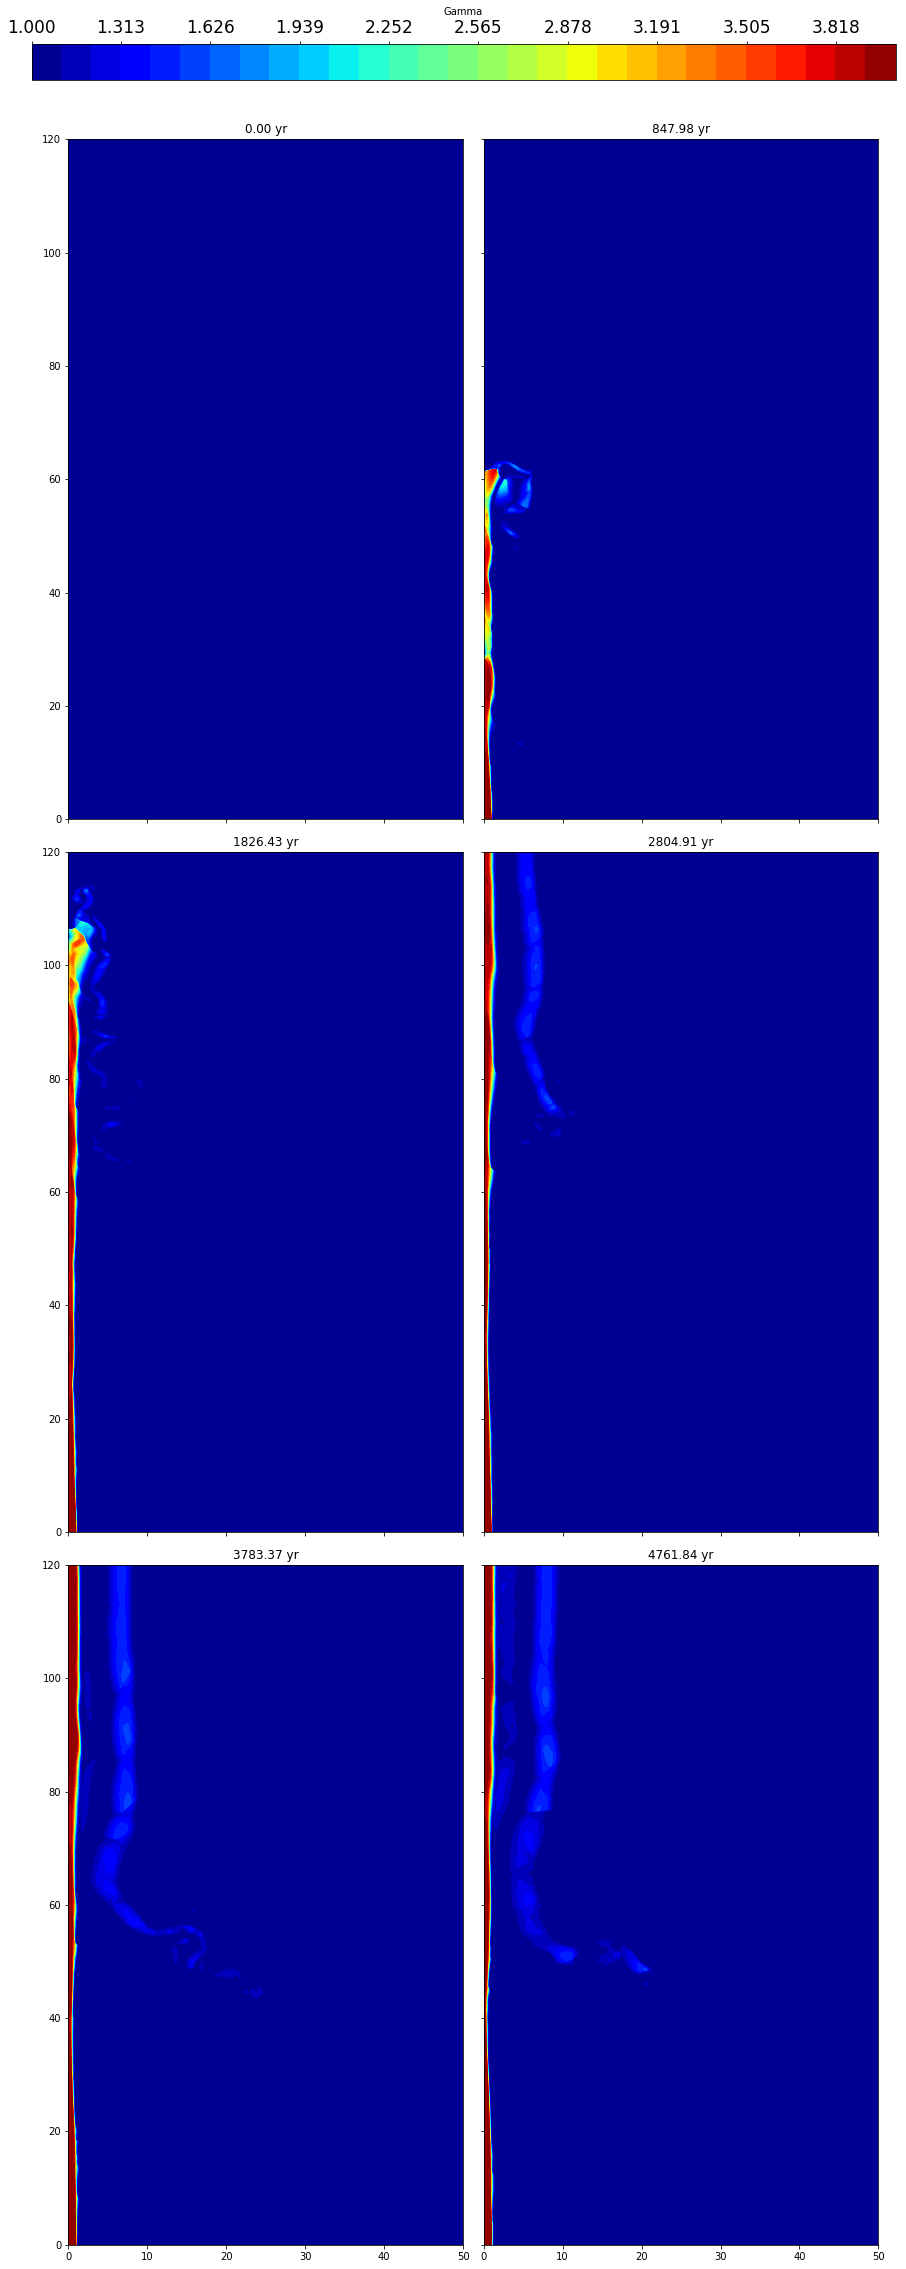

In [129]:
plot_gamma(M)

In [32]:
def plot_prs(M,log=False,rows=3,cols=2):
    scale=(6,10)
    PU=M['PU'].item()
    X=M['X']*PU['L']
    Y=M['Y']*PU['L']    
    T=np.linspace(0,M['T'].shape[0]-1,rows*cols,dtype=int)

    #with quantity_support():
    fig, axes = plt.subplots(nrows=rows, ncols=cols, sharex=True, sharey=True,figsize=(cols*scale[0],rows*scale[1]))
    for i,ax in enumerate(axes.flat):
        varcf=np.log10(M['PRS']) if log else M['PRS']*PU['prs']
        varc=np.log10(M['Bphi']**2) if log else (M['Bphi']*PU['Bx3'])**2
        varcf[varcf==-np.inf]=0
        varc[varc==-np.inf]=0
        pcf=ax.contourf(X.to(u.pc),Y.to(u.pc),varcf[T[i],:,:],levels=np.linspace(varcf.min(),varcf.max(),20),cmap='Greys',alpha=0.7)
        pc=ax.contour(X.to(u.pc),Y.to(u.pc),varc[T[i],:,:],levels=np.linspace(varc.min(),varc.max(),6))
        ax.set_title('{:.2f}'.format((M['T'][T[i]]*PU['T']).to(u.yr)))
    plt.tight_layout()
    cbar_ax = fig.add_axes([0., 1.015, 1., 0.025*(np.float(cols)/rows)])#*(np.float(cols)/rows)
    cb=fig.colorbar(pcf, cax=cbar_ax,orientation="horizontal",label='PRS')
    cb.ax.tick_params(labelsize=17)
    cb.ax.xaxis.offsetText.set(size=20)
    cb.ax.xaxis.set_ticks_position('top')
    cb.ax.xaxis.set_label_position('top')

In [65]:
from matplotlib import rc,rcParams
rcParams['figure.figsize'] = (22,16)

In [69]:
np.log10(M['Bphi'][10,:,:]**2).max()

/home/astromix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


-5.0033641962626865

In [71]:
np.log10(M['PRS'][10,:,:]/M['Bphi'][10,:,:]**2).max()

/home/astromix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/astromix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in true_divide
  """Entry point for launching an IPython kernel.


inf

In [72]:
np.log10(M['PRS'][10,:,:]/M['Bphi'][10,:,:]**2).min()

/home/astromix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/astromix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in true_divide
  """Entry point for launching an IPython kernel.


-3.0616387948540638

/home/astromix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/astromix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in true_divide
  """Entry point for launching an IPython kernel.


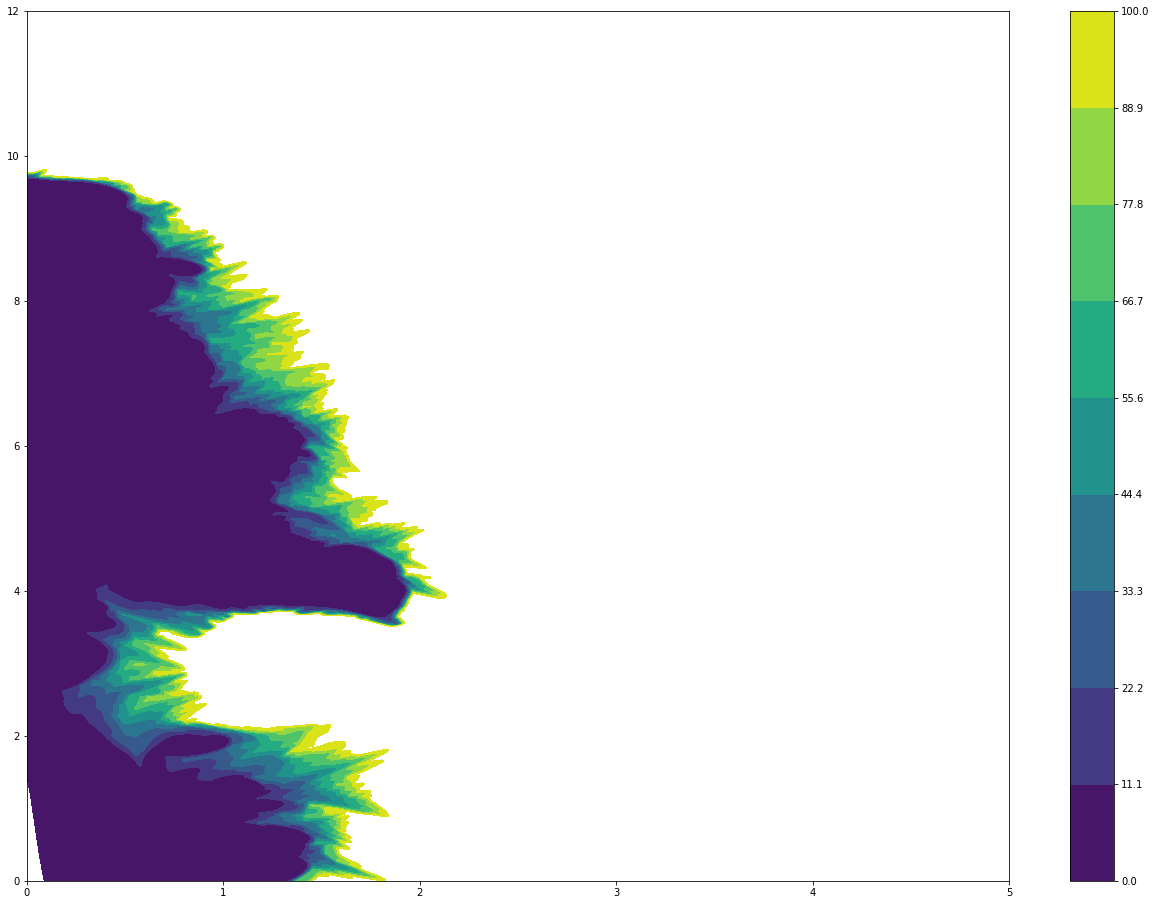

In [81]:
plt.contourf(M['X'],M['Y'],np.log10(M['PRS'][10,:,:]/M['Bphi'][10,:,:]**2),levels=np.linspace(0,100,10))

#plt.contourf(M['X'],M['Y'],np.log10(M['rho'][10,:,:]),levels=np.linspace(-4,5,10))
plt.colorbar()

In [111]:
gamma=1./np.sqrt(1-(M['Vz']**2+M['Vr']**2))

In [119]:
PU['Bx3']

<Quantity 0.13733583 G>

/home/astromix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


(0, 0.25)

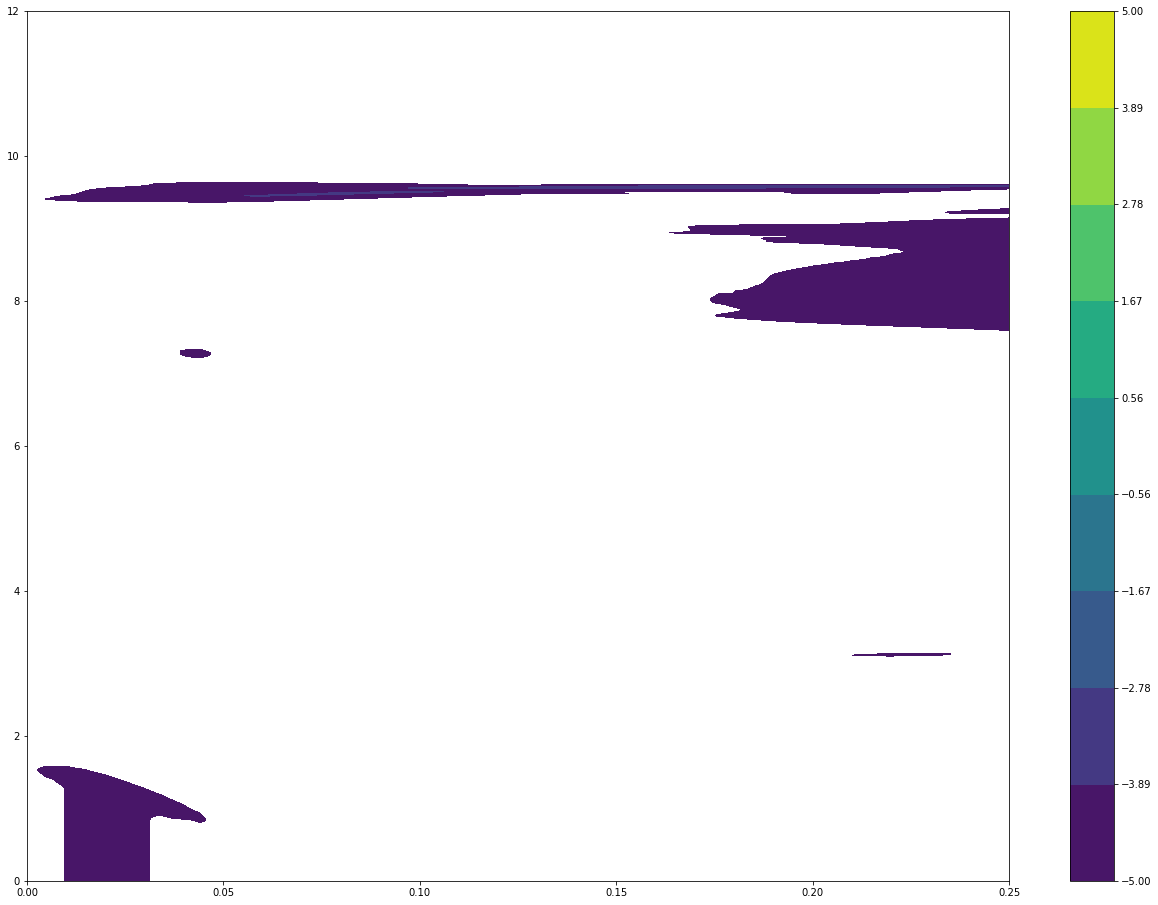

In [117]:
plt.contourf(M['X'],M['Y'],np.log10(M['Bphi'][10,:,:]**2/(gamma[10,:,:]**2*M['RHO'][10,:,:])),levels=np.linspace(-5,5,10))
plt.colorbar()
plt.xlim(0,0.25)

/home/astromix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


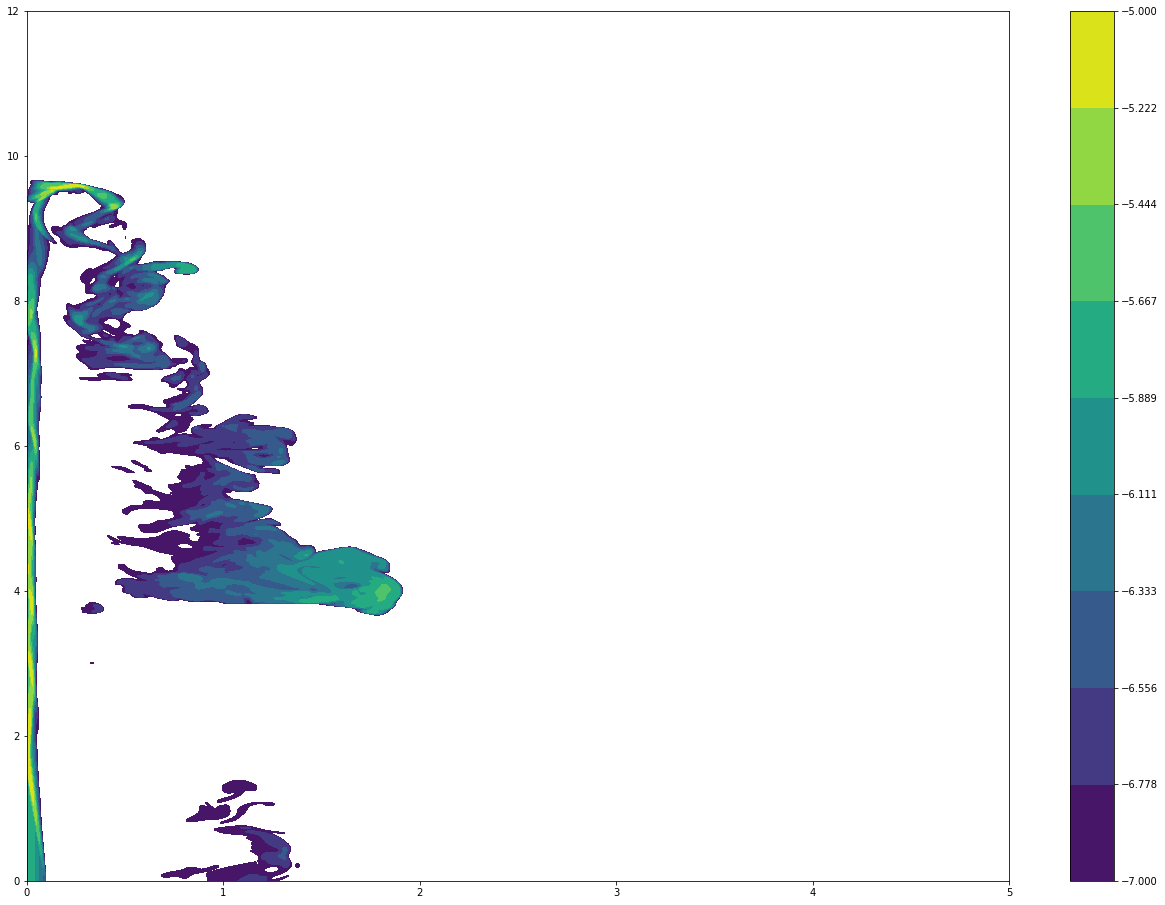

In [70]:
plt.contourf(M['X'],M['Y'],np.log10(M['Bphi'][10,:,:]**2),levels=np.linspace(-7,-5,10))
plt.colorbar()

/home/astromix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


CPU times: user 1min 3s, sys: 3.39 s, total: 1min 7s
Wall time: 32 s


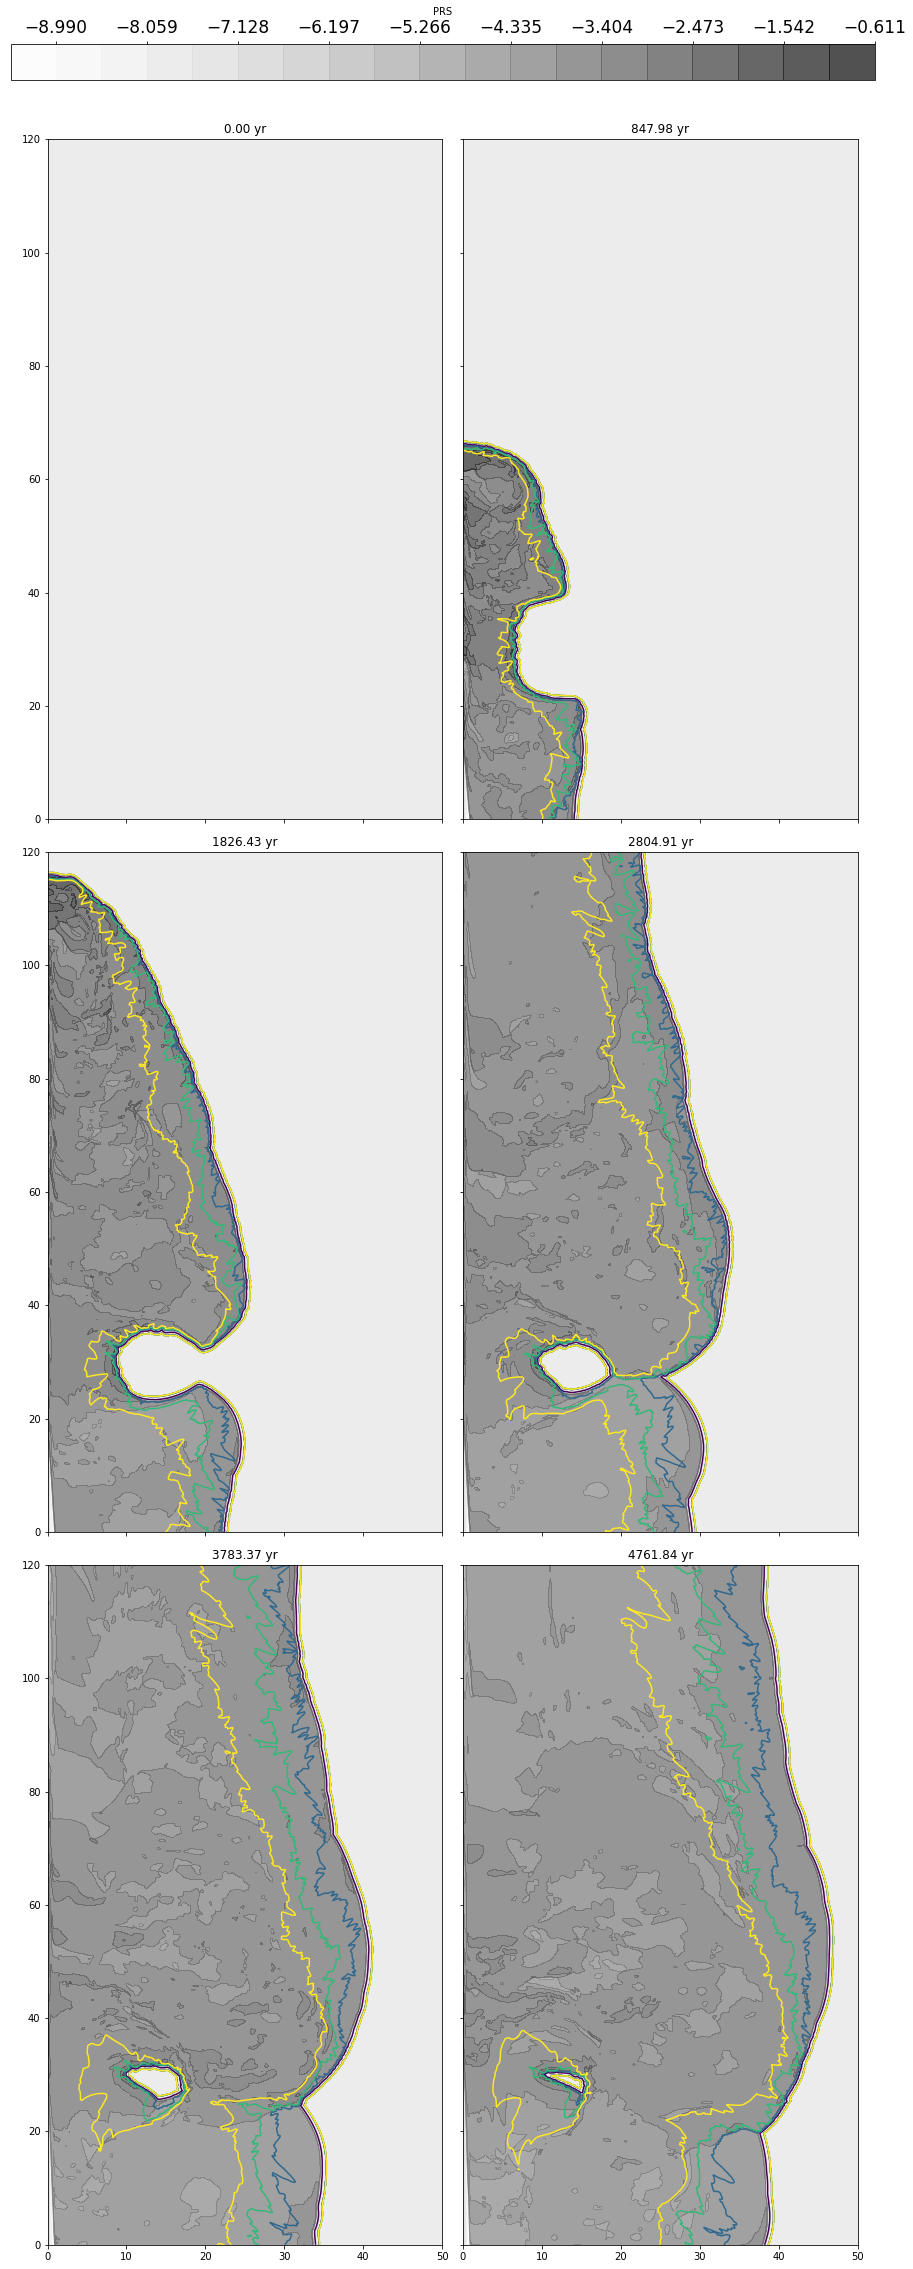

In [33]:
%%time
plot_prs(M,log=True)

In [60]:
def plot_tmp(M,log=False,rows=3,cols=2):
    scale=(6,10)
    PU=M['PU'].item()
    X=M['X']*PU['L']
    Y=M['Y']*PU['L']    
    T=np.linspace(0,M['T'].shape[0]-1,rows*cols,dtype=int)

    #with quantity_support():
    fig, axes = plt.subplots(nrows=rows, ncols=cols, sharex=True, sharey=True,figsize=(cols*scale[0],rows*scale[1]))
    for i,ax in enumerate(axes.flat):
        varcf=np.log10(M['TMP']) if log else M['PRS']*PU['prs']
        varc=np.log10(M['Bphi']) if log else (M['Bphi']*PU['Bx3'])
        varcf[varcf==-np.inf]=0
        varc[varc==-np.inf]=0
        pcf=ax.contourf(X.to(u.pc),Y.to(u.pc),varcf[T[i],:,:],levels=np.linspace(varcf.min(),varcf.max(),20),cmap='jet',alpha=0.75)
        pc=ax.contourf(X.to(u.pc),Y.to(u.pc),varc[T[i],:,:],levels=np.linspace(np.nanmin(varc),np.nanmax(varc),8),linewidths=2)
        ax.set_title('{:.2f}'.format((M['T'][T[i]]*PU['T']).to(u.yr)))
    plt.tight_layout()
    cbar_ax = fig.add_axes([0., 1.015, 1., 0.025*(np.float(cols)/rows)])#*(np.float(cols)/rows)
    cb=fig.colorbar(pcf, cax=cbar_ax,orientation="horizontal",label='TMP')
    cb.ax.tick_params(labelsize=17)
    cb.ax.xaxis.offsetText.set(size=20)
    cb.ax.xaxis.set_ticks_position('top')
    cb.ax.xaxis.set_label_position('top')

/home/astromix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/home/astromix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == '':


CPU times: user 2min 58s, sys: 6.44 s, total: 3min 4s
Wall time: 59 s


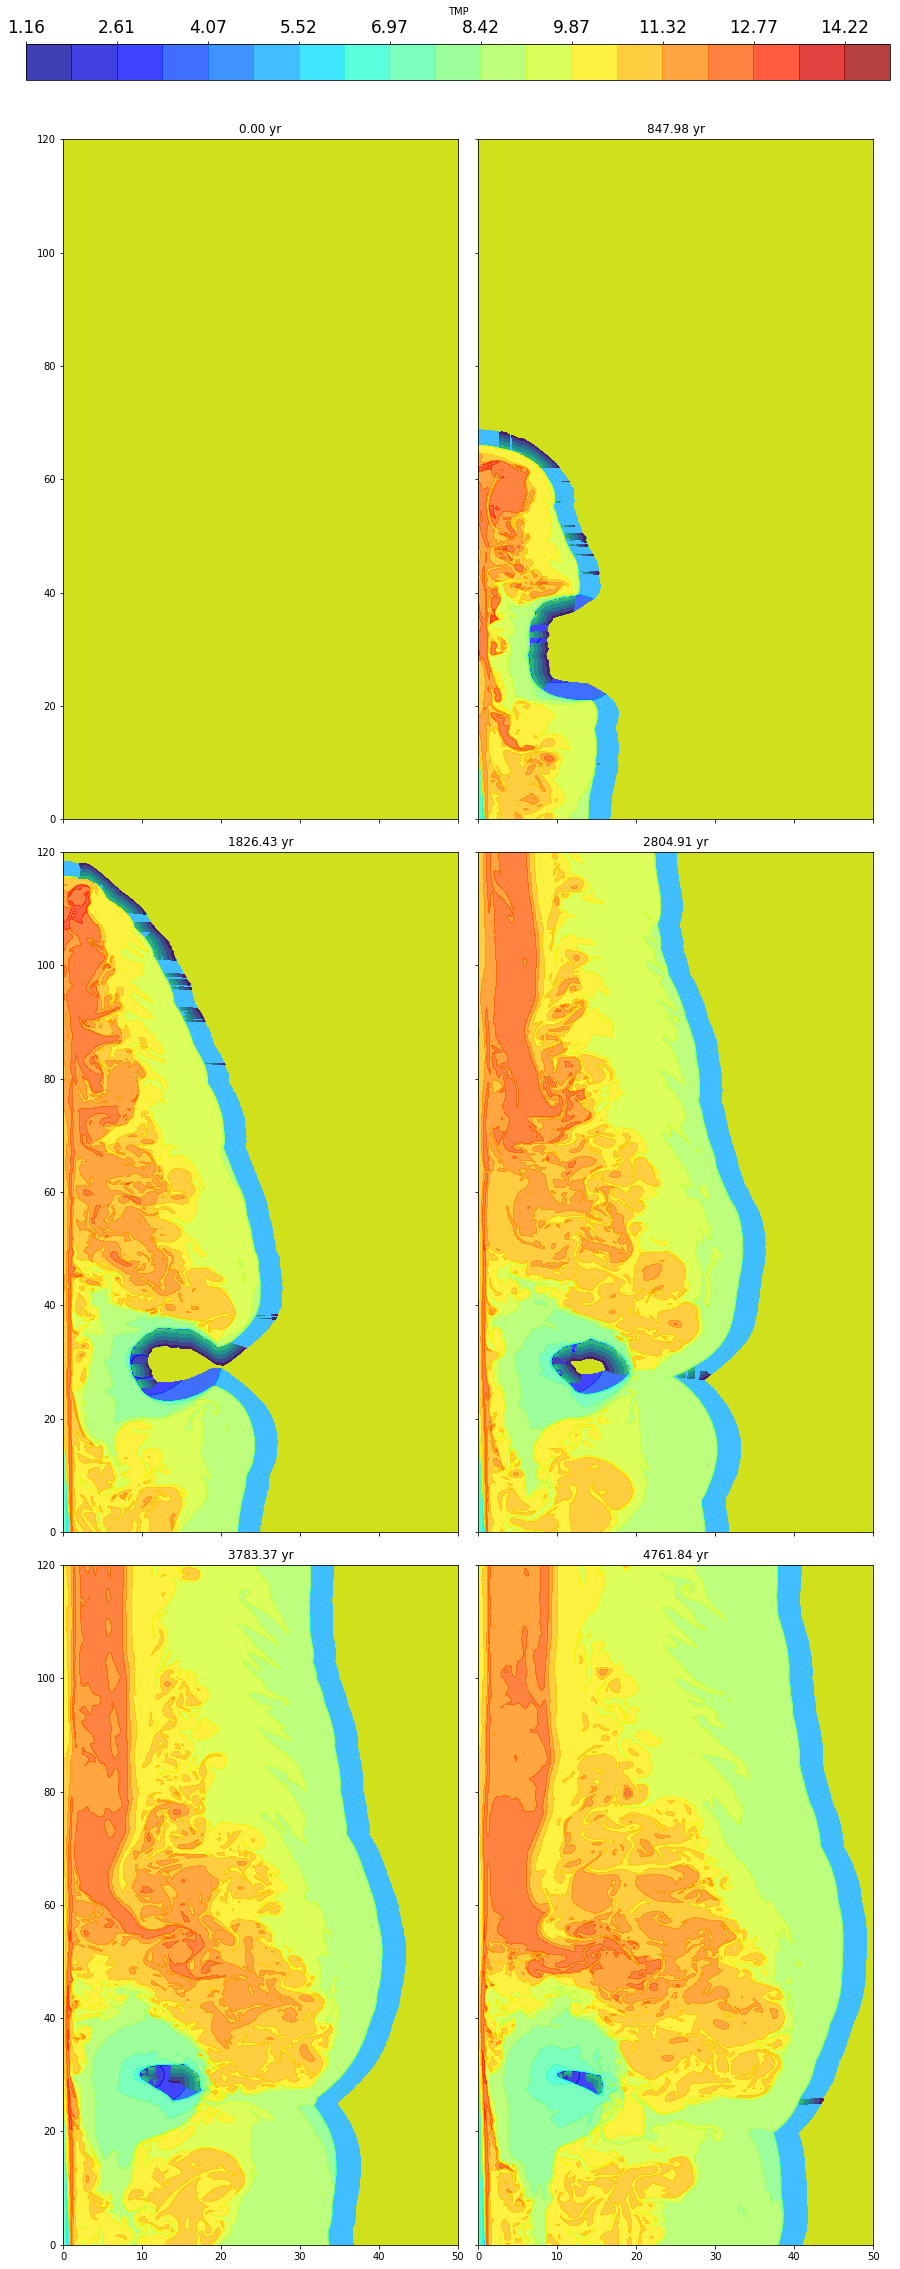

In [61]:
%%time
plot_tmp(M,log=True)

In [58]:
def plot_rho(M,log=False,rows=3,cols=2):
    scale=(6,10)
    PU=M['PU'].item()
    X=M['X']*PU['L']
    Y=M['Y']*PU['L']    
    T=np.linspace(0,M['T'].shape[0]-1,rows*cols,dtype=int)

    #with quantity_support():
    fig, axes = plt.subplots(nrows=rows, ncols=cols, sharex=True, sharey=True,figsize=(cols*scale[0],rows*scale[1]))
    for i,ax in enumerate(axes.flat):
        varcf=np.log10(M['RHO']) if log else M['rho']*PU['rho']
        #varc=np.log10(M['Bphi']) if log else (M['Bphi']*PU['Bx3'])
        varcf[varcf==-np.inf]=0
        #varc[varc==-np.inf]=0
        pcf=ax.contourf(X.to(u.pc),Y.to(u.pc),varcf[T[i],:,:],levels=np.linspace(varcf.min(),varcf.max(),20),cmap='jet',alpha=0.7)
        #pc=ax.contour(X.to(u.pc),Y.to(u.pc),varc[T[i],:,:],levels=np.linspace(varc.min(),varc.max(),6))
        ax.set_title('{:.2f}'.format((M['T'][T[i]]*PU['T']).to(u.yr)))
    plt.tight_layout()
    cbar_ax = fig.add_axes([0., 1.015, 1., 0.025*(np.float(cols)/rows)])#*(np.float(cols)/rows)
    cb=fig.colorbar(pcf, cax=cbar_ax,orientation="horizontal",label='TMP')
    cb.ax.tick_params(labelsize=17)
    cb.ax.xaxis.offsetText.set(size=20)
    cb.ax.xaxis.set_ticks_position('top')
    cb.ax.xaxis.set_label_position('top')

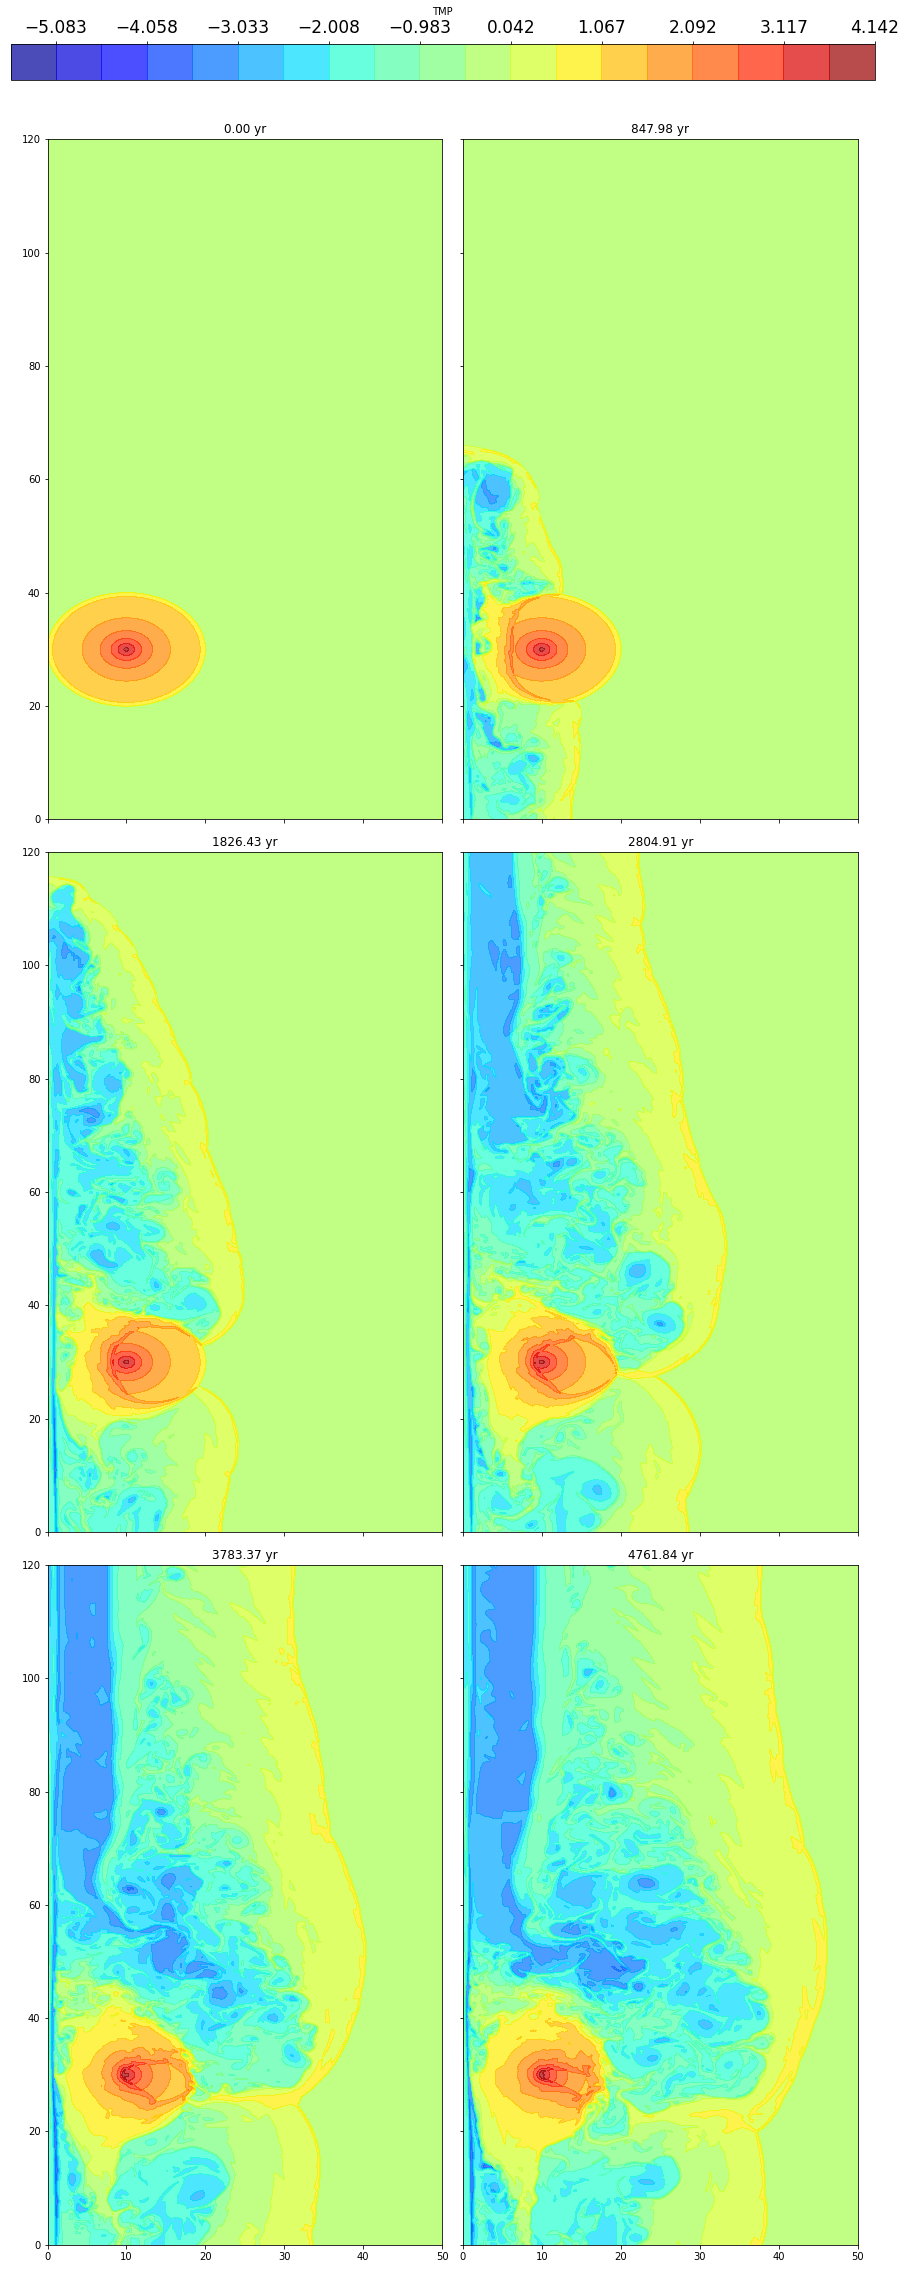

In [59]:
plot_rho(M,log=True)